# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

Host Id                         int64
Host Since                     object
Name                           object
Property Type                  object
Review Scores Rating (bin)    float64
Room Type                      object
Zipcode                       float64
Beds                          float64
Number of Records               int64
Number Of Reviews               int64
Price                           int64
Review Scores Rating          float64
Neighborhood                   object
dtype: object
    Host Id Host Since                                Name Property Type  \
0   5162530        NaN     1 Bedroom in Prime Williamsburg     Apartment   
1  33134899        NaN     Sunny, Private room in Bushwick     Apartment   
2  39608626        NaN                Sunny Room in Harlem     Apartment   
3       500  6/26/2008  Gorgeous 1 BR with Private Balcony     Apartment   
4       500  6/26/2008            Trendy Times Square Loft     Apartment   

   Review Scores Rating (bin)      

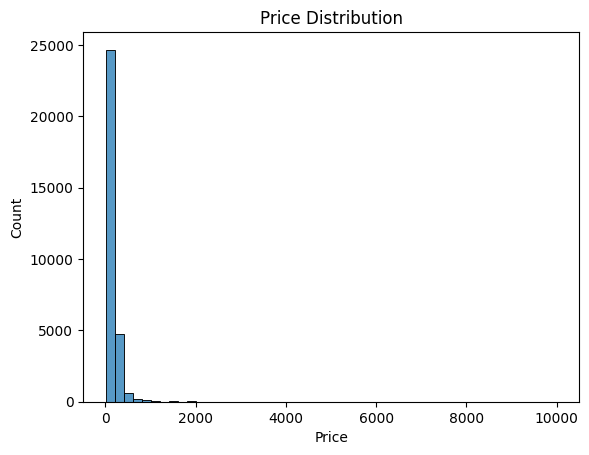

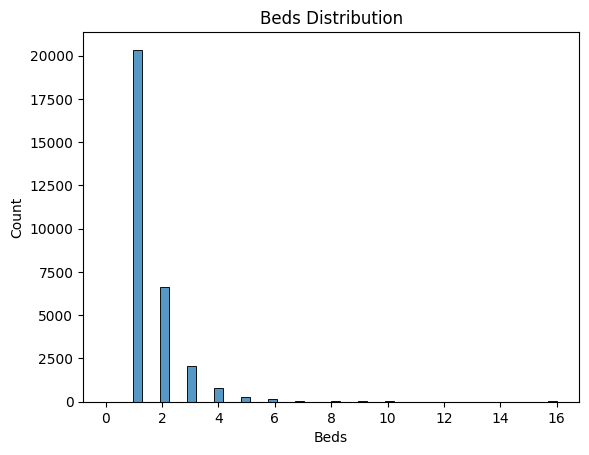

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/airbnb_hw.csv')
df['Neighborhood'] = df['Neighbourhood ']
df.drop(columns=['Neighbourhood '], inplace=True)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''), errors='coerce')
print(df.dtypes)
print(df.head())

sns.histplot(df['Price'], bins=50)
plt.title('Price Distribution')
plt.show()

sns.histplot(df['Beds'], bins=50)
plt.title('Beds Distribution')
plt.show()


In [83]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['Property Type', 'Room Type', 'Neighborhood']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)
df['Host Since'] = pd.to_datetime(df['Host Since']).dt.strftime("%Y%m%d")
df = df.dropna()
print(df.head())

   Host Id Host Since                                 Name  \
4      500   20080626             Trendy Times Square Loft   
5     1039   20080725   Big Greenpoint 1BD w/ Skyline View   
6     1783   20080812                         Amazing Also   
7     2078   20080815  Colorful, quiet, & near the subway!   
8     2339   20080820  East Village Cocoon: 2 Bedroom Flat   

   Review Scores Rating (bin)  Zipcode  Beds  Number of Records  \
4                        95.0  10036.0   3.0                  1   
5                       100.0  11222.0   1.0                  1   
6                       100.0  10004.0   1.0                  1   
7                        90.0  11201.0   1.0                  1   
8                        90.0  10009.0   2.0                  1   

   Number Of Reviews  Price  Review Scores Rating  ...  \
4                 39    549                  96.0  ...   
5                  4    149                 100.0  ...   
6                  9    250                 100.0 

In [84]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Price', 'Name'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 17609
Test set size: 4403


In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate RMSE and R^2 for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate RMSE and R^2 for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Training RMSE: {train_rmse:.2f}, Training R^2: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, Test R^2: {test_r2:.2f}")

Training RMSE: 132.74, Training R^2: 0.25
Test RMSE: 106.83, Test R^2: 0.32


Rsq:  0.22580761875405986
Partial R^2:  0.15211973934477774


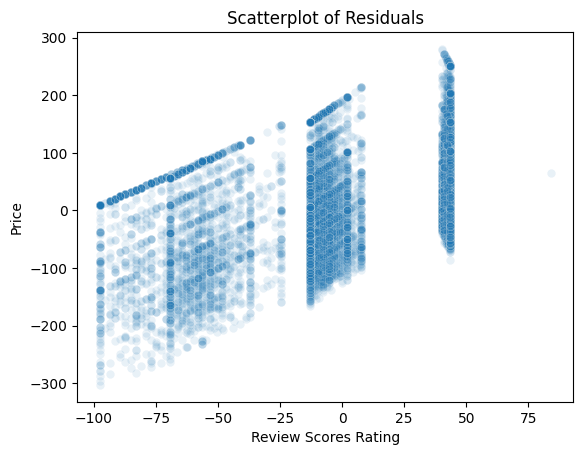

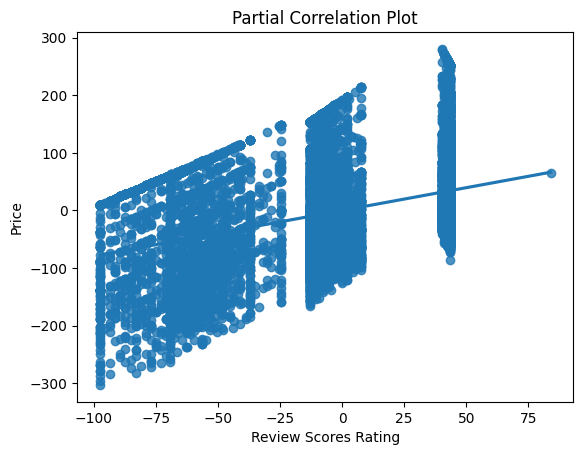

In [ ]:
def winsorize(x):
    # Convert from pd to np, if necessary:
    if type(x) == 'pandas.core.series.Series':
        x = x.to_numpy()
    # Compute IQR and 25, 75 quantiles:
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Winsorize x:
    x_winsor = np.copy(x)
    x_winsor[ x < lower_whisker ] = lower_whisker
    x_winsor[ x > upper_whisker ] = upper_whisker
    return(x_winsor)

df2 = df # Let's start over, again
df2.loc[:, ['Beds','Price','Review Scores Rating'] ] = df2.loc[:,['Beds','Price','Review Scores Rating'] ].apply(winsorize)
y = df2['Price'] # Target variable
df2['Beds X Review Scores Rating'] = df2['Beds']*df2['Review Scores Rating'] # Interaction term
#X_d = pd.get_dummies(df['brand'],dtype='int',drop_first=True) # Create brand dummies
X_n = df2.loc[:,['Beds','Review Scores Rating', 'Beds X Review Scores Rating']]
#X = pd.concat([X_n,X_d],axis=1)
X = X_n
reg = LinearRegression(fit_intercept=True).fit(X, y) # Fit the linear model
print('Rsq: ', reg.score(X,y) )

var =  'Review Scores Rating' #'Number of Records X age_ihs'
x_k = X[var]
X_mk = X.drop(var,axis=1)

## 1. Regress y on x\k, save residual r_y
reg_y = LinearRegression(fit_intercept=False).fit(X_mk, y) # Fit the linear model
r_y = y - reg_y.predict(X_mk)

## 2. Regress x_k on x\k, save residual r_x
reg_k = LinearRegression(fit_intercept=False).fit(X_mk, x_k) # Fit the linear model
r_x = x_k - reg_k.predict(X_mk)

## 3. Plot r_y against r_k
reg = LinearRegression().fit(r_x.to_numpy().reshape(-1, 1),r_y.to_numpy())
print('Partial R^2: ', reg.score(r_x.to_numpy().reshape(-1, 1),r_y.to_numpy()) )
sns.scatterplot(y=r_y, x=r_x,alpha=.1).set(title='Scatterplot of Residuals')
plt.show()

sns.regplot(y=r_y, x=r_x).set(title='Partial Correlation Plot')
plt.show()

# number of records just graphs almost as a parallelogram, not a line

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
complex_model = LinearRegression()
complex_model.fit(X_train_poly, y_train)
y_train_pred_poly = complex_model.predict(X_train_poly)
y_test_pred_poly = complex_model.predict(X_test_poly)
train_rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
train_r2_poly = r2_score(y_train, y_train_pred_poly)
test_rmse_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
test_r2_poly = r2_score(y_test, y_test_pred_poly)
print(f"Complex Model - Training RMSE: {train_rmse_poly:.2f}, Training R^2: {train_r2_poly:.2f}")
print(f"Complex Model - Test RMSE: {test_rmse_poly:.2f}, Test R^2: {test_r2_poly:.2f}")

# RMSE improves, but R^2 is worse -- overfitting?

Complex Model - Training RMSE: 69.75, Training R^2: 0.23
Complex Model - Test RMSE: 69.00, Test R^2: 0.22


My main takeaway from this is that it's easy to look at our model results and go, "This isn't very good and we should optimize some more," and then proceed to include interactions and create a new model that can result in lower RMSE (and maybe some other statistics) but is generally poorer-fitting. We should be careful about the overfitting risks of a kitchen-sink approach and focus on using a carefully-selected model first with the original variables before adding in interactions and other complications.